# Recorte 2014 - 2016 -> Ação

In [1]:
# Importando bibliotecas necessárias para a construção de grafos
import netpixi
from netpixi.integration.gt import *
from regression.integration.gt import *
import pandas as pd
import numpy as np
import csv
import ast
import cpnet
from graph_tool import spectral
import seaborn as sns
import regression as reg
import cpnet

from scipy import stats
from matplotlib import pyplot as plt
from graph_tool import centrality
from graph_tool import spectral

<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/site-packages/seaborn/rcmod.py:82: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/usr/local/lib/python3.10/site-packages/setuptools/_distutils/version.py:346: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
<frozen importlib._bootstrap>:914: ImportWarning: VendorImporter.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.10/site-packages/seaborn/cm.py:1582: PendingDeprecationWarning: The register_cmap function will be deprecated in a future version. Use ``matplotlib.colormaps.register(name)`` instead.
  mpl_cm.register_cmap(_name, _cmap)
/usr/local/lib/python3.10/site-packages/seaborn/cm.py:1583: PendingDeprecationWarning: The register_cmap function will b

In [2]:
df = pd.read_csv('./Video_Games_Sales_as_at_22_Dec_2016.csv')
df.dropna(subset=['Publisher'], inplace=True)
df = df.loc[~df['Critic_Score'].isna() & ~df['User_Score'].isna() & ~df['Rating'].isna()]

In [3]:
df.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8.0,322.0,Nintendo,E
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8.0,192.0,Nintendo,E
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,Nintendo,E
7,Wii Play,Wii,2006.0,Misc,Nintendo,13.96,9.18,2.93,2.84,28.92,58.0,41.0,6.6,129.0,Nintendo,E


In [4]:
df_recortado = df.loc[(df['Year_of_Release'] >= 2014) & (df['Year_of_Release'] <= 2016) & (df['Genre'] == 'Action')] 

In [5]:
df_recortado.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
42,Grand Theft Auto V,PS4,2014.0,Action,Take-Two Interactive,3.96,6.31,0.38,1.97,12.61,97.0,66.0,8.3,2899.0,Rockstar North,M
165,Grand Theft Auto V,XOne,2014.0,Action,Take-Two Interactive,2.81,2.19,0.00,0.47,5.48,97.0,14.0,7.9,764.0,Rockstar North,M
231,Uncharted: The Nathan Drake Collection,PS4,2015.0,Action,Sony Computer Entertainment,2.07,1.71,0.08,0.76,4.62,86.0,78.0,8.1,1264.0,Bluepoint Games,T
295,Watch Dogs,PS4,2014.0,Action,Ubisoft,1.40,1.90,0.11,0.64,4.05,80.0,80.0,6.3,2996.0,Ubisoft Montreal,M
304,Assassin's Creed: Unity,PS4,2014.0,Action,Ubisoft,1.19,2.07,0.08,0.62,3.96,70.0,40.0,4.9,2050.0,"Ubisoft, Ubisoft Montreal",M


In [6]:
df_recortado.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 221 entries, 42 to 16696
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             221 non-null    object 
 1   Platform         221 non-null    object 
 2   Year_of_Release  221 non-null    float64
 3   Genre            221 non-null    object 
 4   Publisher        221 non-null    object 
 5   NA_Sales         221 non-null    float64
 6   EU_Sales         221 non-null    float64
 7   JP_Sales         221 non-null    float64
 8   Other_Sales      221 non-null    float64
 9   Global_Sales     221 non-null    float64
 10  Critic_Score     221 non-null    float64
 11  Critic_Count     221 non-null    float64
 12  User_Score       221 non-null    float64
 13  User_Count       221 non-null    float64
 14  Developer        221 non-null    object 
 15  Rating           221 non-null    object 
dtypes: float64(10), object(6)
memory usage: 29.4+ KB


In [7]:
df_recortado.Year_of_Release.value_counts()

2014.0    80
2015.0    74
2016.0    67
Name: Year_of_Release, dtype: int64

In [8]:
publishers = df_recortado["Publisher"].unique()

In [9]:
gamergate_action_graph = Graph(directed=False) # não-dirigido
gamergate_action_graph.add_vp('Publisher')
gamergate_action_graph.add_vp('Games_released')
gamergate_action_graph.add_ep('strength')

for pub in publishers:
    gamergate_action_graph.add_vertex(pub)
    gamergate_action_graph.get_vertex(pub)['Publisher'] = pub
    num_games = df_recortado['Name'].loc[df_recortado["Publisher"] == pub].nunique() 
    gamergate_action_graph.get_vertex(pub)['Games_released'] = num_games

In [10]:
sorted_years = list(range(2014, 2017))
print(sorted_years)

[2014, 2015, 2016]


In [11]:
df_list = []

margem = 4
for i in range(0, len(sorted_years), margem):
    df_list.append(df_recortado[df_recortado['Year_of_Release'].isin(sorted_years[i:i+margem])])

In [12]:
publisher_platforms = []
for db in df_list:
    publisher_platforms.append(db.groupby('Platform')['Publisher'].unique().to_dict())

In [13]:
for platform_dict in publisher_platforms:
    for platform, publishers in platform_dict.items():
        for i in range(len(publishers)):
            if i != len(publishers)-1:
                next_vertex = i+1
                while(next_vertex < len(publishers)):
                    if(publishers[i] != publishers[next_vertex] and not gamergate_action_graph.has_edge(publishers[i], publishers[next_vertex])):
                        gamergate_action_graph.add_edge(publishers[i], publishers[next_vertex])
                        gamergate_action_graph.get_edge(publishers[i], publishers[next_vertex])['strength'] = 1
                        next_vertex += 1
                    else:
                        gamergate_action_graph.get_edge(publishers[i], publishers[next_vertex])['strength'] += 1
                        next_vertex += 1

In [14]:
print('número de vértices de g:', gamergate_action_graph.num_vertices())

número de vértices de g: 36


In [15]:
print('número de arestaas de g:', gamergate_action_graph.num_edges())

número de arestaas de g: 426


In [16]:
gt_save(gamergate_action_graph, 'gamergate_action_graph.net.gz')

In [17]:
g = gt_load('gamergate_action_graph.net.gz')
g = gt_clean(g)
cc = centrality.closeness(g)
g.add_vp('closeness', cc)
m = gt_draw.sfdp_layout(g)
gt_move(g, m)
gt_save(g, 'gamergate_action_sfdp.net.gz')

# Análise

<AxesSubplot: xlabel='Global_Sales', ylabel='Count'>

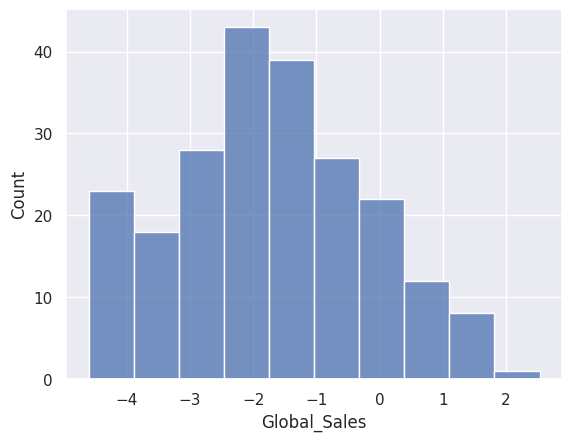

In [18]:
sns.histplot(np.log(df_recortado['Global_Sales']))

# Reconhecimento X Sucesso

In [19]:
df_rec_suc = df_recortado.copy()

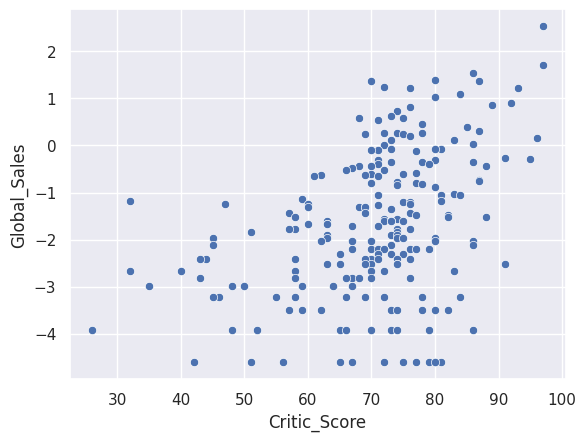

In [20]:
sns.scatterplot(x=df_rec_suc['Critic_Score'], y=np.log(df_rec_suc['Global_Sales']));

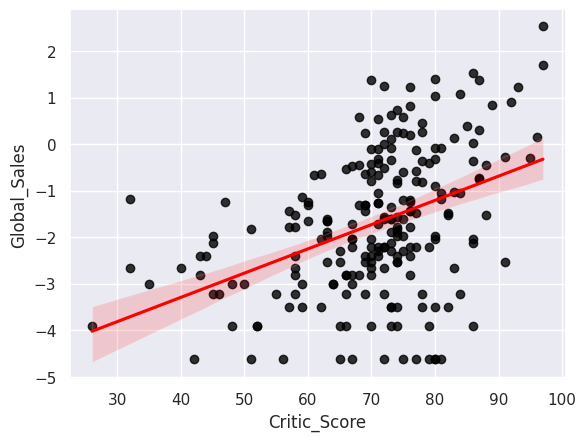

In [21]:
sns.regplot(x=df_rec_suc['Critic_Score'], y=np.log(df_rec_suc['Global_Sales']), scatter_kws={"color": "black"}, line_kws={"color": "red"});

In [22]:
result = reg.linear(data=df_rec_suc, formula='np.log(Global_Sales) ~ Critic_Score')

In [23]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.171
Model:                              OLS   Adj. R-squared:                  0.167
Method:                   Least Squares   F-statistic:                     45.10
Date:                  Tue, 15 Nov 2022   Prob (F-statistic):           1.59e-10
Time:                          15:26:08   Log-Likelihood:                -386.43
No. Observations:                   221   AIC:                             776.9
Df Residuals:                       219   BIC:                             783.7
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -5.3723      0.555     -9.680      0.000      -6.466      -4.279
Critic_Score     0.0521      0.008      6.716      0.000       0.037       0.067
==============================================================================
Omnibus:                        2.992   Durbin-Watson:                   0.290
Prob(Omnibus):                  0.224   Jarque-Bera (JB):                3.052
Skew:                          -0.261   Prob(JB):                        0.217
Kurtosis:                       2.758   Cond. No.                         423.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
result.micro_summary()

variable,coefficient,std error,p-value
Critic_Score,0.052058,0.007751,0.000000


In [25]:
result.nano_summary()

+0.052 (0.008) ***


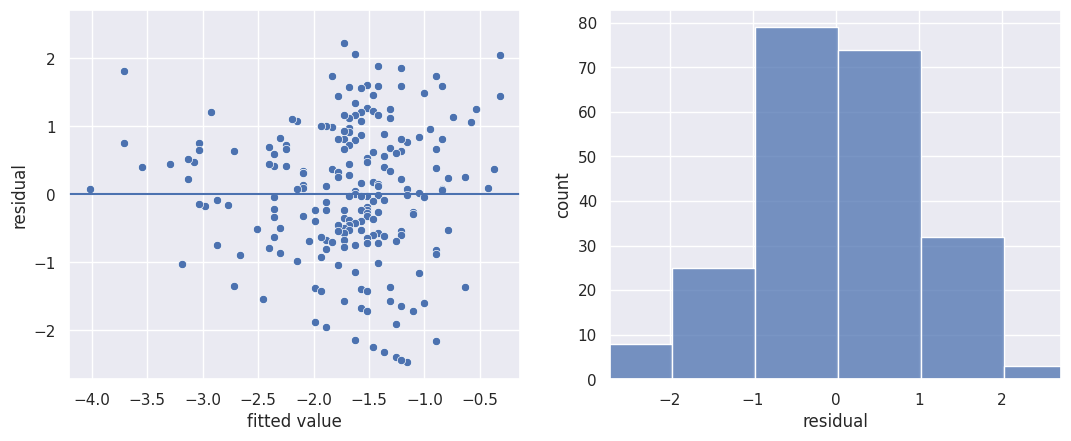

In [26]:
result.plot_residuals()

# Faixa etária X Sucesso

In [27]:
df_rat_suc = df_recortado.copy()
df_rat_suc.loc[df_rat_suc['Rating'] == 'E', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'E10+', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'K-A', 'Rating'] = 1
df_rat_suc.loc[df_rat_suc['Rating'] == 'M', 'Rating'] = 0
df_rat_suc.loc[df_rat_suc['Rating'] == 'T', 'Rating'] = 0
df_rat_suc.loc[df_rat_suc['Rating'] == 'AO', 'Rating'] = 0
df_rat_suc.loc[df_rat_suc['Rating'] == 'RP', 'Rating'] = 0

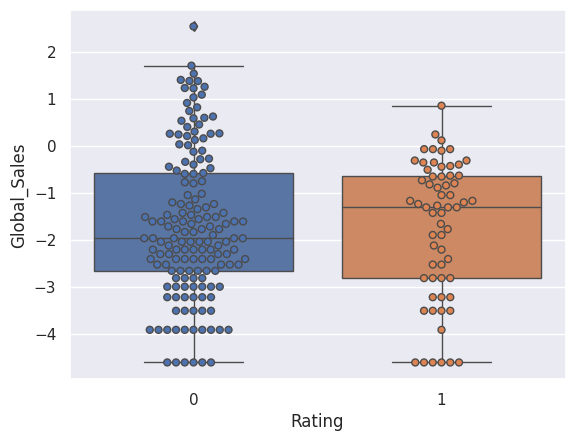

In [28]:
sns.boxplot(x=df_rat_suc['Rating'], y=np.log(df_rat_suc['Global_Sales']), linewidth=1)
sns.swarmplot(x=df_rat_suc['Rating'], y=np.log(df_rat_suc['Global_Sales']), linewidth=1);

In [29]:
result = reg.linear(data=df_rat_suc, formula='np.log(Global_Sales) ~ Rating')

In [30]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     np.log(Global_Sales)   R-squared:                       0.000
Model:                              OLS   Adj. R-squared:                 -0.004
Method:                   Least Squares   F-statistic:                   0.05109
Date:                  Tue, 15 Nov 2022   Prob (F-statistic):              0.821
Time:                          15:26:08   Log-Likelihood:                -407.10
No. Observations:                   221   AIC:                             818.2
Df Residuals:                       219   BIC:                             825.0
Df Model:                             1                                         
Covariance Type:              nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -1.6841      0.122    -13.802      0.000      -1.925      -1.444
Rating[T.1]    -0.0517      0.229     -0.226      0.821      -0.502       0.399
==============================================================================
Omnibus:                        3.800   Durbin-Watson:                   0.004
Prob(Omnibus):                  0.150   Jarque-Bera (JB):                2.797
Skew:                           0.127   Prob(JB):                        0.247
Kurtosis:                       2.511   Cond. No.                         2.44
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [31]:
result.nano_summary()

-0.052 (0.229)


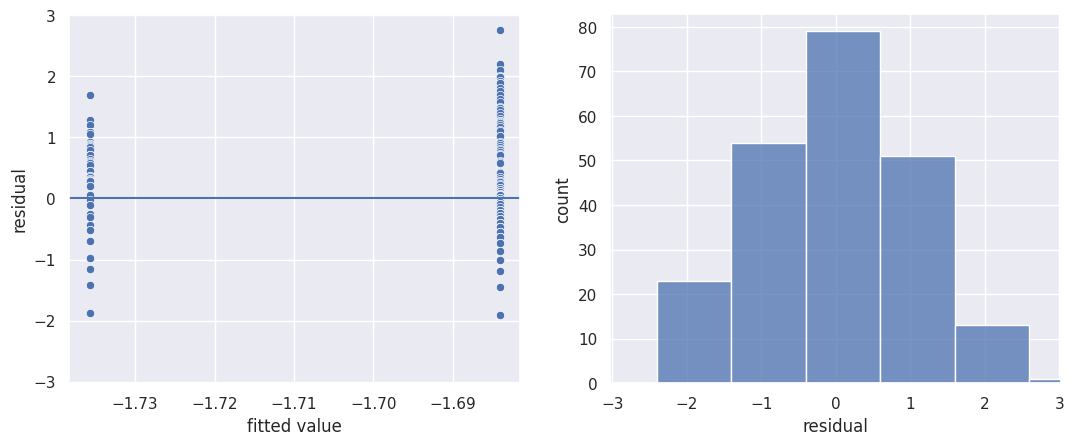

In [32]:
result.plot_residuals()